In [299]:
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns

import os

In [136]:
RANDOM_STATE = 42

In [109]:
dataset_dir = "/home/sam/Desktop/datasets/used-cars/"
os.listdir(dataset_dir)

['train.csv', 'sample_submission.csv', 'train_ideal.csv', 'test.csv']

In [110]:
df = pd.read_csv(dataset_dir + "train.csv")

In [111]:
df.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

# Cleaning Data

Time to take a look and clean this data.

From a first glance, there is lots of unstructured data in the `engine` column that would be really useful.

## Formatting Engine

From first glance, we have a common format of:
`(digits)HP` `(digits)L` `ENGINE INFORMATION` `FUEL TYPE`

If you would like to remove all of the rows that don't confirm to a structure similar to this, I have used 'awk' to simply get all the columns that contain horsepower, liter and cylinder information. 
This leaves us with ~150,000 rows of data.

The following command was used
> awk -F, 'NR==1 || $7~/HP/ && /Cylinder/ && /L/' train.csv > train_ideal.csv

I have not opted not to use this dataset and used regex to extract the information and imputed missing information. 

In [112]:
df['horsepower'] = df['engine'].str.findall('.+?(?=HP)').str[0].astype(float)
df['liters'] = df['engine'].str.findall(' .+?(?=L\s)').str[0].astype(float)
df['cylinders'] = df['engine'].str.findall('\d.?(?=Cylinder)').str[0].astype(float)

In [113]:
df = df[[
    "id",
    "brand",
    "model",
    "model_year",
    "milage",
    "fuel_type",
    "horsepower",
    "liters",
    "cylinders",
    "transmission",
    "ext_col",
    "int_col",
    "accident",
    "clean_title",
    "price"
]]

### Electric Cars

Noticeably, around 5000 cars are missing information on fuel type and these tend to be electric cars (Tesla or E-cars). With that in mind, we will create a new type of binary column for electric or not.

In fact, if you view only Tesla's, it seems like this generated dataset made a mistake and some fuel types are listed as Gasoline - a mistake. 

We are going to make the assumption that all vehicles without registered fuel types are electric.

In [114]:
df.loc[df['fuel_type'].isna(), 'fuel_type'] = 'Electric'

In [140]:
df.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type           0
horsepower      33259
liters          37886
cylinders       37855
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

### Imputing Data

Much of the data is missing so we are going to fill in the data.

For the relevant columns, we will inspect any potential relationship with the price before modelling.

The relevant columns are:
- horsepower (Q)
- liters (Q)
- cylinders (Q)
- accident (N)
- clean_title (N)

The Q and N stand for quantitative and nominal/categorical data.

#### Accident Report 

In [141]:
alt.Chart(
    df['accident'].value_counts().reset_index(name='counts'),
    title='Distribution of Accident Reports'
).mark_bar().encode(
    x=alt.X('counts:Q'),
    y=alt.Y('index'),
    tooltip=[alt.Tooltip('counts', title='Count', format=',')]
)

alt.Chart(...)

In [142]:
sampled_df = df[~df['accident'].isna()].sample(5000, random_state=RANDOM_STATE)

selection = alt.selection_point(fields=['accident'])
color = alt.condition(
    selection,
    alt.Color('accident:N').legend(None),
    alt.value('lightgray')
)

acc_price_chart = alt.Chart(
    sampled_df,
    title='Price against Accidents'
).mark_point().encode(
    x=alt.X('price:Q'),
    y=alt.Y('accident:N'),
    color=color,
    tooltip=[
        alt.Tooltip('model'),
        alt.Tooltip('price', format=',')
    ]
)

legend = alt.Chart(
    sampled_df
).mark_point().encode(
    alt.Y('accident:N').axis(orient='right'),
    color=color
).add_params(
    selection
)

chart = acc_price_chart | legend
chart

alt.HConcatChart(...)

Obviously, we see a higher price with less accident reports. We can also view this numerically

We use the median as there are cars with significantly higher prices than the norm, as can be seen from the graph.

In [132]:
df.groupby('accident').price.median()

accident
At least 1 accident or damage reported    18000.0
None reported                             35000.0
Name: price, dtype: float64

Hence, from this information, there is clearly a relation and we should consider modelling this data to fill in the missing data effectively.


In [157]:
accidents_per_year = df.groupby('model_year').accident.value_counts().reset_index(name='count')

alt.Chart(
    accidents_per_year
).mark_bar().encode(
    x=alt.X('accident:N'),
    y=alt.Y('count'),
    color='accident',
    column='model_year',
    tooltip=[alt.Tooltip('count', format=',')]
)

alt.Chart(...)

In [234]:
accident_counts = df.groupby('model_year').accident.count()
accident_happened = accidents_per_year[accidents_per_year['accident'] == "At least 1 accident or damage reported"]
accident_happened = accident_happened.set_index('model_year')['count']

x = list(accident_counts.keys())
y = []
for key in accident_counts.keys():
    total = accident_counts.get(key, 0)
    happened = accident_happened.get(key, 0)
    y.append(happened/total)

ratio_df = pd.DataFrame(data={'model_year':x, 'accident_ratio':y})

In [250]:
alt.Chart(
    ratio_df,
    title='Accident Ratio against Model Year'
).mark_bar().encode(
    x=alt.X('model_year:N'),
    y=alt.Y('accident_ratio:Q'),
    tooltip=[alt.Tooltip('accident_ratio', title='Accident Ratio', format='.3f')]
)

alt.Chart(...)

We can see a general trend where we see less accidents in sold cars as we progress in years, following 2010. This tracks as newer cars will have less time to be involved in an accident.

Following this visual, I am going to fill in the accident null values with respect to the model year.

In [279]:
dist = dict(ratio_df.set_index('model_year')['accident_ratio'])
options = ["At least 1 accident or damage reported", "None reported"]

In [285]:
accidents = df[df['accident'].isna()].apply(
    lambda x : np.random.choice(
        options, 
        p=[dist[x['model_year']], 1-dist[x['model_year']]]
    ),
    axis=1
)
df.loc[df['accident'].isna(), 'accident'] = accidents

#### Clean Titles

As there is only one non-nan value 'Yes', we are going to fill all of the NaN values with 'No', by logical assumption.

However, this may be a point to come back to and reconsider.

In [295]:
df['clean_title'].fillna('No', inplace=True)

### Horsepower Imputing

We will quickly look for a relation between horsepower and the other features.

<Axes: >

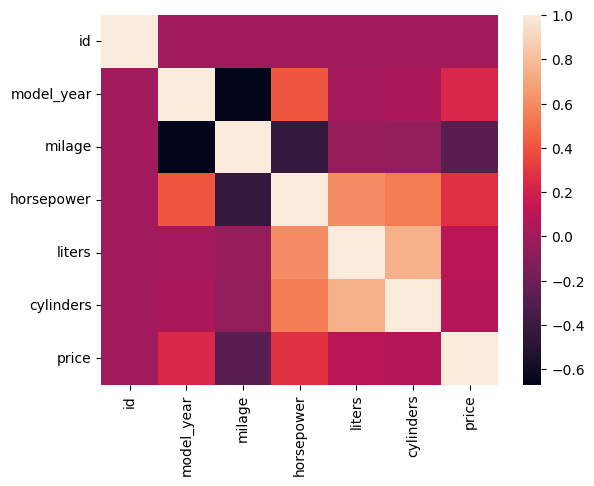

In [300]:
sns.heatmap(df.corr())

Unsurprisingly, `horsepower` is most strongly linked to `litres` and `cylinders` - information that is also missing so cannot be used for imputing.

The next best bit relation to horsepower is actually the `model_year`. Hence, we shall use the model year to determine the horsepower. `price` cannot be used as that is the label. 

In [319]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [363]:
hp_train, hp_test = train_test_split(df[~df['horsepower'].isna()], test_size=0.2, random_state=RANDOM_STATE)

pred_table = hp_train.groupby("model_year").horsepower.median()

y_test = hp_test['horsepower']
hp_test['horsepower'] = np.nan

grouped_median_pred = hp_test.apply(lambda x : pred_table.get(x['model_year']), axis=1)
median_pred = hp_test['horsepower'].fillna(hp_train['horsepower'].median())

mse_grouped = mean_squared_error(y_test, grouped_median_pred)
mse_median = mean_squared_error(y_test, median_pred)

print(f"{mse_grouped=:.2f}")
print(f"{mse_mean=:.2f}")

mse_grouped=10879.76
mse_mean=13377.77


Looks like grouping is better, even if the MSE is really high. 

In [367]:
pred_table = df.groupby("model_year").horsepower.median()
df['horsepower'] = df.groupby("model_year").horsepower.transform(lambda x: x.fillna(x.median()))
# If any values still NaN, take the horsepower of the previous year.
df['horsepower'].fillna(method='ffill', inplace=True)

/home/sam/anaconda3/envs/used-cars/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Cylinder Imputing

Due to the low number of unique values in cylinders, we can impute using categorical methods. 

THIS IS TEMPORARY METHOD AS WE DO SOME MODELLING WITH CURRENT SITUATION

In [372]:
df['cylinders'].fillna(method='ffill', inplace=True)
df['liters'].fillna(method='ffill', inplace=True)

## Creating Categories

For our relevant categories, we will focus on the brand and colours

In [414]:
alt.Chart(
    df.groupby('brand').price.mean().reset_index(name='mean_price'),
    title='Average Price per Brand'
).mark_bar().encode(
    x=alt.X('mean_price:Q', title='Price'),
    y=alt.Y('brand', title='Car Brand', sort='-x'),
    tooltip=[alt.Tooltip('mean_price', format=',.2f')]
)

alt.Chart(...)

Clearly, we have car brands which are more expensive. As opposed to having so many brands, we are going to sort these into sections of premiums based on brand.

### Branding

In [435]:
price_ordered_brands = df.groupby(
    'brand'
).price.mean().reset_index(
    name='mean_price'
).sort_values(
    by='mean_price', 
    ascending=False
).values[:, 0]

expensive_brands = price_ordered_brands[:8]
premium_brands = price_ordered_brands[8:19]
normal_brands = price_ordered_brands[19:29]
cheap_brands = price_ordered_brands[29:]

def brand_quality(brand_name):
    if brand_name in expensive_brands:
        return "expensive"
    elif brand_name in premium_brands:
        return "premium"
    elif brand_name in normal_brands:
        return "normal"
    elif brand_name in cheap_brands:
        return "cheap"
    else:
        return "other"

df["brand_quality"] = df.apply(lambda x: brand_quality(x["brand"]), axis=1)

### Colours

In [443]:
import matplotlib.colors as mcolors

In [449]:
def get_matplot_color(colors):
    for color in colors.split():
        if (color.lower() in mcolors.cnames.keys()):
            return color.lower()
    return color.lower()

In [454]:
top_ext_colors = df["ext_col"].apply(get_matplot_color).value_counts(ascending=False).index[:10]
top_int_colors = df["int_col"].apply(get_matplot_color).value_counts(ascending=False).index[:10]

def assign_cols(col, top_cols):
    if col in top_cols:
        return col
    return "other"

df["ext_col"] = df.apply(lambda x: assign_cols(x["ext_col"], top_ext_colors), axis=1)
df["int_col"] = df.apply(lambda x: assign_cols(x["int_col"], top_int_colors), axis=1)

## Modelling

The time has arrived for the introduction of modelling.

This will be relatively simple as we use pycaret.

In [456]:
modelling_df = df.copy()

nominal_cols = ["brand", "model", "accident", "clean_title", "cylinders"]
numerical_cols = ["model_year", "milage", "horsepower", "liters"]

for col in nominal_cols:
    modelling_df[col] = modelling_df[col].astype('category').cat.codes

In [457]:
prediction_cols = nominal_cols + numerical_cols
relevant_cols = prediction_cols + ['price']
modelling_df = modelling_df[relevant_cols]

x_modelling = modelling_df[prediction_cols]
y_modelling = modelling_df['price']

In [458]:
X_train, X_test, y_train, y_test = train_test_split(
    x_modelling,
    y_modelling,
    test_size=0.2
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25
)

In [477]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error


In [478]:
xgbr = XGBRegressor()
gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100)

gbr.fit(X_train, y_train)
xgbr.fit(X_train, y_train)

models = [
    ("xgbr, 
    gbr
]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [476]:
for name, model in models:
    predictions = model.predict(X_val)
    root_mean_squared_error(y_val, predictions)

71702.9130893546